In [25]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'

chromID = 'chr11'
card = 4

f1 = f'{dataDir}projMatPlots_cellLines/matrices/projMat_Int_HCC1954_Card{card}_{chromID}.pkl'
f2 = f'{dataDir}projMatPlots_cellLines/matrices/projMat_Int_HG002_Card{card}_{chromID}.pkl'
f3 = f'{dataDir}projMatPlots_cellLines/matrices/projMat_Int_GM12878_Card{card}_{chromID}.pkl'

d1 = f'{dataDir}projMatPlots_cellLines/matrices/IncDF_IntReads_HCC1954_Card{card}_{chromID}.pkl'
d2 = f'{dataDir}projMatPlots_cellLines/matrices/IncDF_IntReads_HG002_Card{card}_{chromID}.pkl'
d3 = f'{dataDir}projMatPlots_cellLines/matrices/IncDF_IntReads_GM12878_Card{card}_{chromID}.pkl'

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dictToDF, dfToDict
# from incidenceToProjection import makeHiC_fromInc
from edgeWeightFormulations import finalBounded, finalBounded_fromEdge

In [26]:
pm1 = pd.read_pickle(f1)
np.fill_diagonal(np.asmatrix(pm1),0)
pm2 = pd.read_pickle(f2)
np.fill_diagonal(np.asmatrix(pm2),0)
pm3 = pd.read_pickle(f3)
np.fill_diagonal(np.asmatrix(pm3),0)

In [27]:
pn1 = pm1 / np.nanmax(pm1)
pn2 = pm2 / np.nanmax(pm2)
pn3 = pm3 / np.nanmax(pm3)

In [28]:
diffMat = pn1.sub(pn2, fill_value=0)
# Extract numeric values following "Bin" in the index
numeric_values = diffMat.index.to_series().str.extract(r'Bin(\d+)', expand=False).astype(int)

# Sort the DataFrame based on numeric values
diffMat_sorted = diffMat.loc[numeric_values.sort_values().index, numeric_values.sort_values().index]

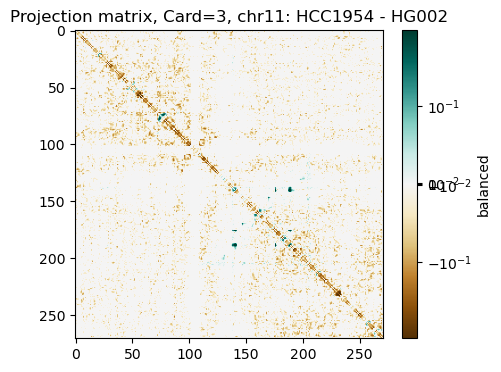

In [30]:
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from matplotlib import colors


plt.figure(figsize=(6, 4))
im = plt.imshow(diffMat_sorted, cmap="BrBG", norm=colors.SymLogNorm(linthresh=0.02, linscale=0.02,
                                              vmin=-0.5, vmax=0.5, base=10))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card=3, {chromID}: HCC1954 - HG002")
plt.show()

In [31]:
pm1_enr = diffMat.where(diffMat >= 0.05, 0)
pm2_enr =  diffMat.where(diffMat <= -0.05, 0)

positive_rows, positive_columns = (pm1_enr > 0).any(axis=1), (pm1_enr > 0).any()
negative_rows, negative_columns = (pm2_enr < 0).any(axis=1), (pm2_enr < 0).any()

In [32]:
id1 = pd.read_pickle(d1)
id2 = pd.read_pickle(d2)
id3 = pd.read_pickle(d3)

In [37]:
multiwayReads_pm1 = id1.loc[positive_rows].sum() > 2
enriched_pm1_incDF = id1.loc[positive_rows,multiwayReads_pm1]
print(enriched_pm1_incDF.shape)

multiwayReads_pm2 = id2.loc[negative_rows].sum() > 2
enriched_pm2_incDF = id2.loc[negative_rows,multiwayReads_pm2]
enriched_pm2_incDF.shape

(88, 1298)


(271, 2662)

In [38]:
enriched_pm2_incDF.head()

,Read1:1,Read2:1,Read3:1,Read4:1,Read5:1,Read6:1,Read7:1,Read8:1,Read9:1,Read10:1,...,Read2653:1,Read2654:1,Read2655:1,Read2656:1,Read2657:1,Read2658:1,Read2659:1,Read2660:1,Read2661:1,Read2662:1
Bin1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Bin3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Bin5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
[i for i,x in enumerate(enriched_pm2_incDF['Read3353:3']) if x==1]

KeyError: 'Read3353:3'

In [11]:
enriched_pm2_incDF['Read3353:3'].index[[94, 98, 166]]

Index(['Bin114', 'Bin118', 'Bin201'], dtype='object')

In [39]:
import hypernetx as hnx
import networkx as nx
import seaborn as sns

HIS_f1 = hnx.Hypergraph.from_incidence_dataframe(enriched_pm2_incDF)

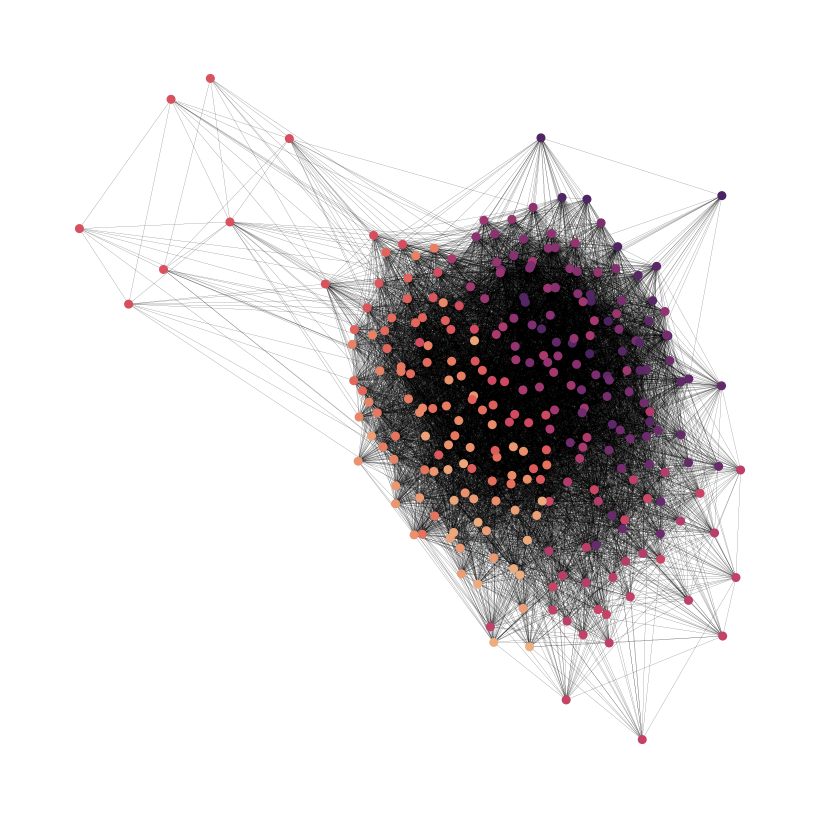

In [40]:
def sort_key(item, delimiter):
    return int(item.split(delimiter)[1])

node_names = sorted(list(list(id2.index)), key=lambda x: sort_key(x,'Bin'))
node_colors = sns.color_palette("flare", n_colors=len(node_names))
color_mapping = dict(zip(node_names, node_colors))

HIS_f1D = HIS_f1.dual()
l_f1d = HIS_f1D.get_linegraph(s = 1)
nx.draw(l_f1d,node_size = 30, 
        with_labels = False, 
        node_color=[color_mapping[node] for node in l_f1d.nodes],
        width = 0.1,
        font_size=5)

(array([407., 447., 417., 350., 308., 260., 171., 122., 145.,  35.]),
 array([0.00369004, 0.10221402, 0.20073801, 0.29926199, 0.39778598,
        0.49630996, 0.59483395, 0.69335793, 0.79188192, 0.8904059 ,
        0.98892989]),
 <BarContainer object of 10 artists>)

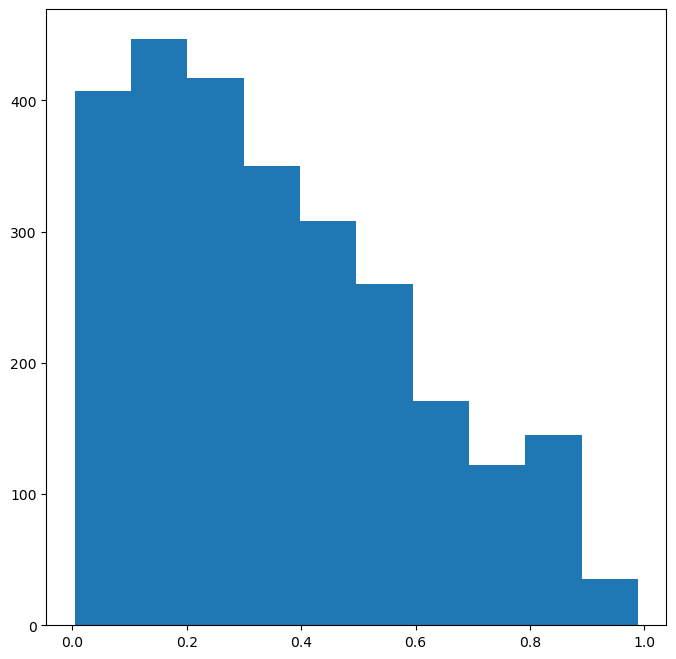

In [42]:
plt.hist(finalBoundedScores)

In [41]:
readSupport = [int(rID.split(":")[1]) for rID in enriched_pm2_incDF.columns]
finalBoundedScores = [finalBounded(list(enriched_pm2_incDF[c])) for c in enriched_pm2_incDF.columns]

# node_importance = [readSupport[i]*finalBoundedScores[i] for i in range(len(readSupport))]
node_importance = readSupport

In [43]:
import pandas as pd
import networkx as nx


df_transposed = enriched_pm2_incDF.transpose()

# Initialize a graph
G = nx.Graph()

# Iterate through each row in the transposed DataFrame
for rName, row in df_transposed.iterrows():
    # Get the nodes that are connected in this row
    connected_nodes = [column for column, value in row.items() if value == 1]
    impValue = node_importance[list(df_transposed.index).index(rName)]
    # Add edges between the connected nodes
    for i in range(len(connected_nodes)):
        for j in range(i+1, len(connected_nodes)):
            node1 = connected_nodes[i]
            node2 = connected_nodes[j]
            # Increment edge weight if edge already exists, otherwise add the edge with weight 1
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += 1*impValue
            else:
                G.add_edge(node1, node2, weight=1*impValue)

# # Print the edges with weights
# for u, v, data in G.edges(data=True):
#     print(f"Node {u} is connected to Node {v} with weight {data['weight']}")

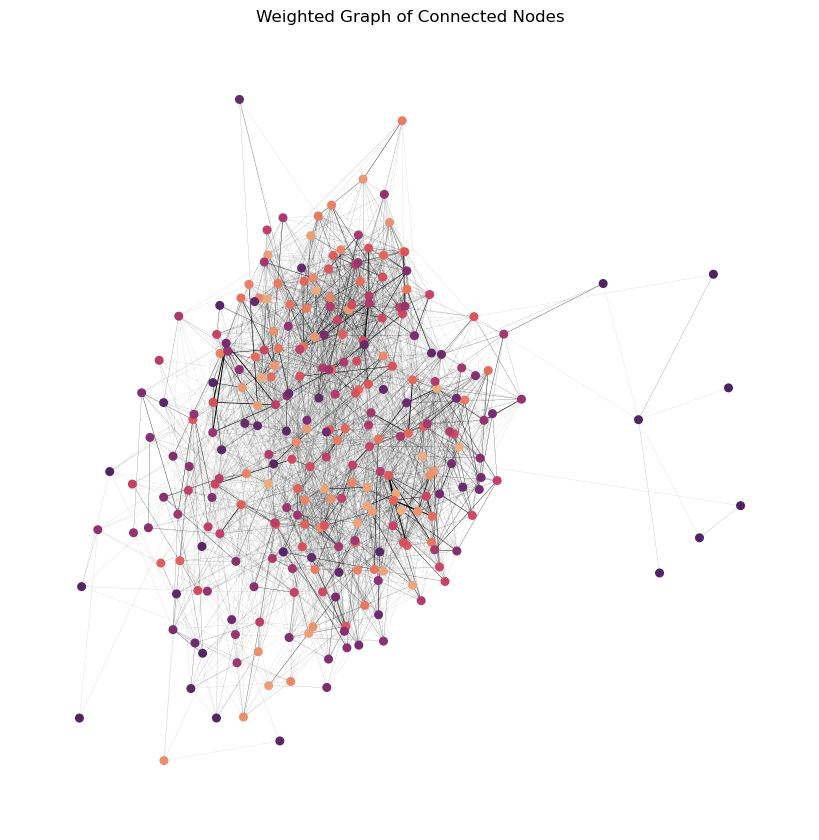

In [44]:
import matplotlib.pyplot as plt


def sort_key(item, delimiter):
    return int(item.split(delimiter)[1])

node_names = sorted(list(list(G.nodes)), key=lambda x: sort_key(x,'Bin'))
node_colors = sns.color_palette("flare", n_colors=len(node_names))
color_mapping = dict(zip(node_names, node_colors))

# Get edge weights
edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]
# Normalize edge weights
min_weight = min(edge_weights)
max_weight = max(edge_weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]

nx.draw(G,node_size = 30, 
        #with_labels = True, 
        node_color=[color_mapping[node] for node in node_names],
        width = normalized_weights,
        # pos = nx.spring_layout(G),
        font_size=5)

plt.title('Weighted Graph of Connected Nodes')
plt.show()

/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


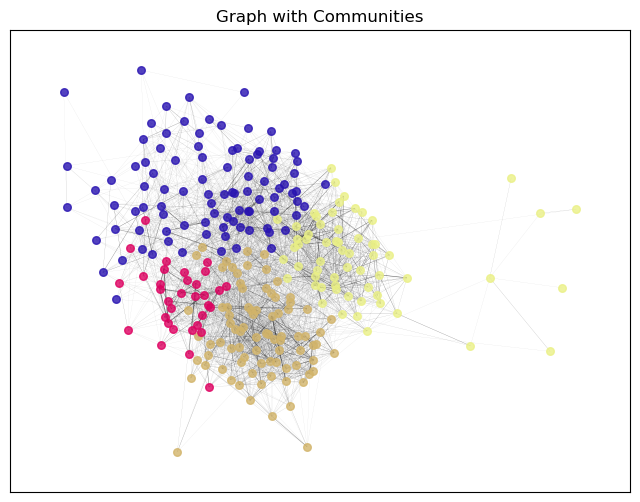

In [45]:
import networkx as nx
import community
import matplotlib.pyplot as plt
import random


# Apply the Louvain method for community detection
partition = community.best_partition(G)

# Generate random colors for each community
color_map = {}
for node, community_id in partition.items():
    if community_id not in color_map:
        color_map[community_id] = (random.random(), random.random(), random.random())  # RGB color tuple

# Plot the graph with nodes colored by community
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Positions of nodes
for community_id, color in color_map.items():
    nodes_in_community = [node for node, cid in partition.items() if cid == community_id]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_color=color, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5,width = normalized_weights)
plt.title('Graph with Communities')
plt.show()

In [46]:
# Print the communities
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [node]
    else:
        communities[community_id].append(node)


print("Communities:")
for community_id, nodes in communities.items():
    print(f"Community {community_id}: {nodes}")

Communities:
Community 2: ['Bin45', 'Bin74', 'Bin76', 'Bin100', 'Bin32', 'Bin33', 'Bin62', 'Bin43', 'Bin44', 'Bin83', 'Bin55', 'Bin97', 'Bin59', 'Bin82', 'Bin113', 'Bin114', 'Bin58', 'Bin75', 'Bin56', 'Bin57', 'Bin111', 'Bin73', 'Bin78', 'Bin79', 'Bin60', 'Bin61', 'Bin88', 'Bin63', 'Bin64', 'Bin52', 'Bin30', 'Bin31', 'Bin53', 'Bin49', 'Bin86', 'Bin87', 'Bin47', 'Bin110', 'Bin54', 'Bin115', 'Bin101', 'Bin102', 'Bin77', 'Bin98', 'Bin46', 'Bin51', 'Bin50', 'Bin81', 'Bin84', 'Bin85', 'Bin80', 'Bin99', 'Bin112', 'Bin48', 'Bin104', 'Bin105', 'Bin108', 'Bin109', 'Bin107', 'Bin103', 'Bin106']
Community 3: ['Bin156', 'Bin15', 'Bin65', 'Bin34', 'Bin41', 'Bin42', 'Bin72', 'Bin19', 'Bin20', 'Bin70', 'Bin14', 'Bin2', 'Bin4', 'Bin91', 'Bin131', 'Bin5', 'Bin40', 'Bin37', 'Bin155', 'Bin13', 'Bin39', 'Bin26', 'Bin96', 'Bin16', 'Bin150', 'Bin94', 'Bin95', 'Bin123', 'Bin124', 'Bin135', 'Bin24', 'Bin71', 'Bin141', 'Bin27', 'Bin120', 'Bin121', 'Bin148', 'Bin11', 'Bin122', 'Bin6', 'Bin125', 'Bin147', 'Bin89

In [47]:
impReads_pm2 = {}
impReads_pm2 = dfToDict(enriched_pm2_incDF,impReads_pm2)
print(list(impReads_pm2.keys())[0:4])

['Bin45_Bin74_Bin76_Bin100', 'Bin156_Bin176_Bin218_Bin219', 'Bin15_Bin32_Bin33_Bin65', 'Bin34_Bin41_Bin42_Bin72']


In [48]:
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'
chromSizes = pd.read_csv(f'{dataDir}hg38.chromSizes',sep="\t", names = ['chr','size']).set_index('chr')['size'].to_dict()
readConcatemersWClosestGene = f'{dataDir}NlaIII_HG002_output_byChr/NlaIII_HG002_{chromID}.gz'
# readConcatemersWClosestGene = f'{dataDir}NlaIII_HCC1954_output_byChr/NlaIII_HCC1954_{chromID}.gz'
# readConcatemersWClosestGene = f'{dataDir}NlaIII_GM12878_output_byChr/NlaIII_GM12878_{chromID}.gz'
colnames = ["chr","start","end","readID","readLen","readQual",
"geneChr","geneStart","geneEnd","strand","geneID","bioType","geneName","dist","ID"]

fullBed_hg = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)
# fullBed_hcc = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)
# fullBed_gm = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)

In [49]:
chrFile = fullBed_hg[fullBed_hg['chr']==chromID]
binSize = 5*10**5 #1*10**6
chrBins = [x for x in range(0,chromSizes[chromID]+binSize,binSize)]
chrFile_binned = pd.cut(chrFile['start'],bins = chrBins, labels = ["Bin"+str(i+1) for i in range(len(chrBins)-1)]).rename("binID")
binStart = [chrBins[i] + 1 for i in chrFile_binned.cat.codes]
binEnd = [chrBins[i+1] for i in chrFile_binned.cat.codes]
chrFile_wBinID = chrFile.assign(binID=chrFile_binned, binStart=binStart, binEnd=binEnd)

In [50]:
chrFile_wBinID.head()

,chr,start,end,readID,readLen,readQual,geneChr,geneStart,geneEnd,strand,geneID,bioType,geneName,dist,ID,binID,binStart,binEnd
0,chr11,60870,61473,Read:9458310_Card:3_Batch:1c575,1521,13,chr11,112967,125927,-,ENSG00000254468,lncRNA,AC069287.1,51495,1,Bin1,1,500000
1,chr11,61199,61424,Read:5173269_Card:7_Batch:1c575,1843,14,chr11,112967,125927,-,ENSG00000254468,lncRNA,AC069287.1,51544,2,Bin1,1,500000
2,chr11,61353,61441,Read:10499627_Card:3_Batch:1c575,1421,6,chr11,112967,125927,-,ENSG00000254468,lncRNA,AC069287.1,51527,3,Bin1,1,500000
3,chr11,70511,70663,Read:13218629_Card:4_Batch:1c575,1314,3,chr11,112967,125927,-,ENSG00000254468,lncRNA,AC069287.1,42305,4,Bin1,1,500000
4,chr11,70659,70740,Read:10109620_Card:4_Batch:1c575,506,7,chr11,112967,125927,-,ENSG00000254468,lncRNA,AC069287.1,42228,5,Bin1,1,500000


In [51]:
groupedBins = chrFile_wBinID.groupby('ID')['binID'].apply(list).reset_index(name='Bins')

In [52]:
groupedBins.head()

,ID,Bins
0,1,[Bin1]
1,2,[Bin1]
2,3,"[Bin1, Bin149, Bin150]"
3,4,[Bin1]
4,5,[Bin1]


In [53]:
def sort_key(item):
    return int(item.split('Bin')[1])

edges = ["_".join(sorted(list(set(a)), key=sort_key)) for a in groupedBins['Bins'] if len(list(set(a))) >= 3]
readIDs = [groupedBins.iloc[ix][0] for ix in range(len(groupedBins)) if len(list(set(groupedBins.iloc[ix][1]))) >= 3]
print(len(edges))
print(len(readIDs))

274564
274564


In [54]:
impReads_pm2 = [readIDs[i] for i,x in enumerate(edges) if x in impReads_pm2]

In [55]:
impRecords_pm2 = chrFile_wBinID[chrFile_wBinID['ID'].isin(impReads_pm2)]
impRecords_pm2.head()

,chr,start,end,readID,readLen,readQual,geneChr,geneStart,geneEnd,strand,geneID,bioType,geneName,dist,ID,binID,binStart,binEnd
1111,chr11,204616,204755,Read:6955529_Card:12_Batch:1c575,5806,30,chr11,167784,207428,-,ENSG00000177951,protein_coding,BET1L,0,1045,Bin1,1,500000
1545,chr11,222008,222143,Read:252953_Card:9_Batch:1c575,4708,27,chr11,215030,236931,-,ENSG00000142082,protein_coding,SIRT3,0,1437,Bin1,1,500000
1568,chr11,222722,223055,Read:17733835_Card:7_Batch:1c575,3786,6,chr11,215030,236931,-,ENSG00000142082,protein_coding,SIRT3,0,1457,Bin1,1,500000
1912,chr11,236165,236271,Read:11022742_Card:4_Batch:1c575,2310,23,chr11,215030,236931,-,ENSG00000142082,protein_coding,SIRT3,0,1748,Bin1,1,500000
1917,chr11,236324,237052,Read:252953_Card:9_Batch:1c575,4708,27,chr11,215030,236931,-,ENSG00000142082,protein_coding,SIRT3,0,1437,Bin1,1,500000


In [56]:
# impRecords_pm1.to_csv(path_or_buf=f'{dataDir}diffAnalysis/diffContactReads_chr11_HCC1954_compGM.tab.gz',index = False,sep = "\t",compression="gzip")
# impRecords_pm2.to_csv(path_or_buf=f'{dataDir}diffAnalysis/diffContactReads_chr11_GM12878_compHCC.tab.gz',index = False,sep = "\t",compression="gzip")

impRecords_pm2.to_csv(path_or_buf=f'{dataDir}diffAnalysis/diffContactReads_chr11_card4_HG002_compHCC.tab.gz',index = False,sep = "\t",compression="gzip")

In [57]:
rxg_pm1 = pd.pivot_table(data=impRecords_pm2[['geneID', 'ID']], index='geneID', columns='ID', aggfunc=lambda x: 1, fill_value=0)
print(rxg_pm1.shape)


(1329, 2745)


In [58]:
def finalBounded_fromEdge(edge,maxPossLen):
    """Same calculation as above except from edge IDs"""
    split_edge = edge.split("_")
    nonZeroBins = [(int(e.split(":")[1])+1)//5 if ":" in e else (int(e.split("Bin")[1])) for e in  split_edge]
    
    rCard = len(split_edge)
    ixFirst = nonZeroBins[0]
    ixLast = nonZeroBins[-1]

    concatemerLen = ixLast - ixFirst + 1
    consecBinCounts = [i - j for i,j in 
                    zip(nonZeroBins[:0:-1],nonZeroBins[-2::-1])].count(1)
    skipLen = (rCard - 1 - consecBinCounts)
    score = (skipLen + 1) * concatemerLen / (rCard * maxPossLen)
    return(score)

In [59]:
maxPossLen = int(list(impRecords_pm2['binID'])[-1].split("Bin")[1])

read_ids_index = {id: index for index, id in enumerate(readIDs)}
readScores = [finalBounded_fromEdge(edges[read_ids_index[i]], maxPossLen) for i in rxg_pm1.columns]

/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/hypernetx/classes/entity.py:1387: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/hypernetx/classes/entity.py:1390: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties[self._misc_props_col] = self.properties[
/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/hypernetx/classes/entity.py:1387: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/hypernetx/classes/entity.

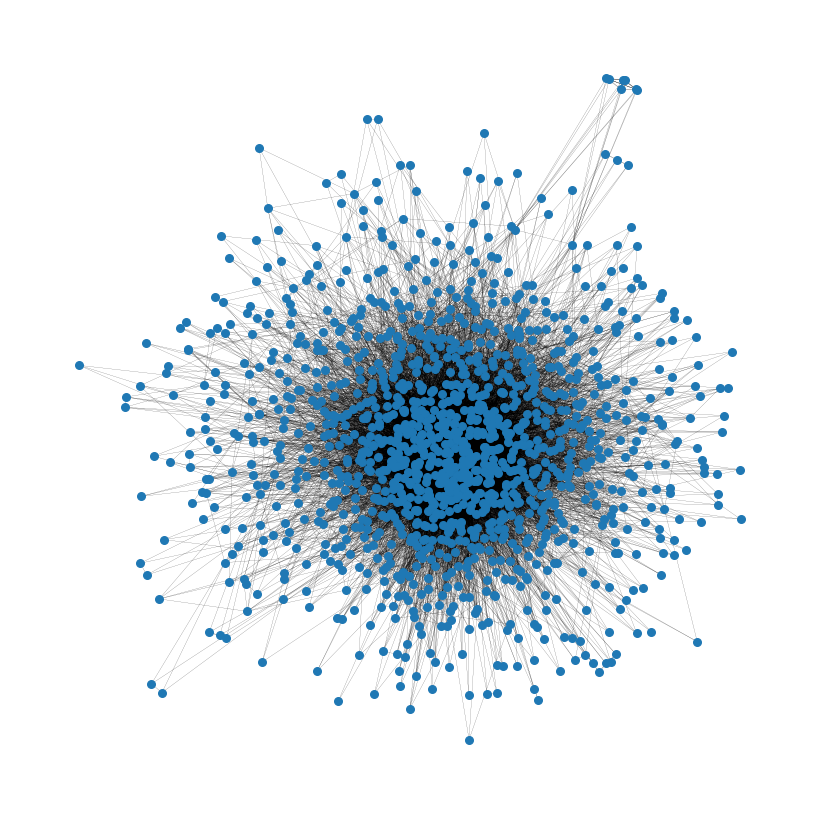

In [60]:
pm1_rxg_hg = hnx.Hypergraph.from_incidence_dataframe(rxg_pm1)

pm1_rxg_hd = pm1_rxg_hg.dual()
l_rxg_pm1 = pm1_rxg_hd.get_linegraph(s = 1)


nx.draw(l_rxg_pm1,node_size = 30, 
        with_labels = False, 
        width = 0.1,
        font_size=5)

In [61]:
df_transposed = rxg_pm1.transpose()

# Initialize a graph
G = nx.Graph()

# Iterate through each row in the transposed DataFrame
for rName, row in df_transposed.iterrows():
    # Get the nodes that are connected in this row
    connected_nodes = [column for column, value in row.items() if value == 1]
    impValue = readScores[list(df_transposed.index).index(rName)]
    # Add edges between the connected nodes
    for i in range(len(connected_nodes)):
        for j in range(i+1, len(connected_nodes)):
            node1 = connected_nodes[i]
            node2 = connected_nodes[j]
            # Increment edge weight if edge already exists, otherwise add the edge with weight 1
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += 1*impValue
            else:
                G.add_edge(node1, node2, weight=1*impValue)

# # Print the edges with weights
# for u, v, data in G.edges(data=True):
#     print(f"Node {u} is connected to Node {v} with weight {data['weight']}")

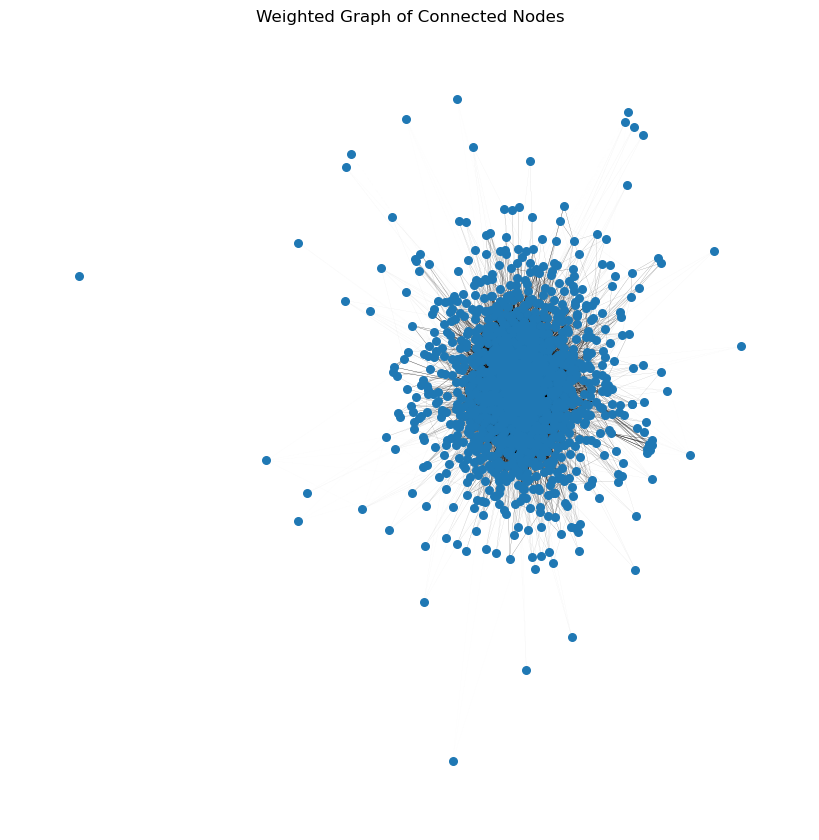

In [64]:
# Get edge weights
edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]
# Normalize edge weights
min_weight = min(edge_weights)
max_weight = max(edge_weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]

nx.draw(G,node_size = 30, 
        #with_labels = True, 
        #node_color=[color_mapping[node] for node in node_names],
        width = normalized_weights,
        pos = nx.spring_layout(G),
        font_size=5)

plt.title('Weighted Graph of Connected Nodes')
plt.show()

/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


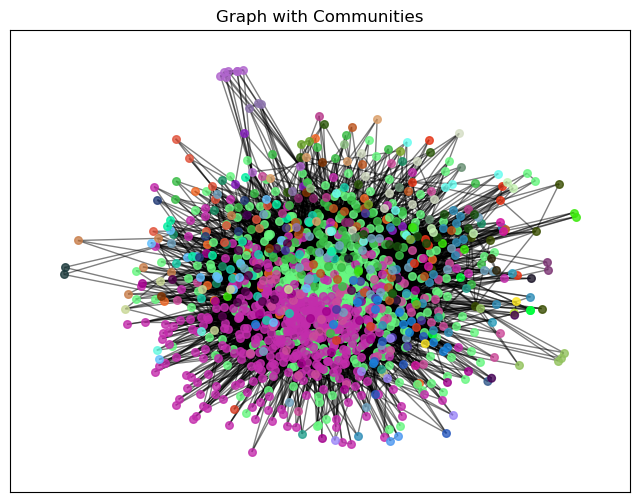

In [65]:
import networkx as nx
import community
import matplotlib.pyplot as plt
import random


# Apply the Louvain method for community detection
partition = community.best_partition(l_rxg_pm1,resolution = 0.8)

# Generate random colors for each community
color_map = {}
for node, community_id in partition.items():
    if community_id not in color_map:
        color_map[community_id] = (random.random(), random.random(), random.random())  # RGB color tuple

# Plot the graph with nodes colored by community
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(l_rxg_pm1)  # Positions of nodes
for community_id, color in color_map.items():
    nodes_in_community = [node for node, cid in partition.items() if cid == community_id]
    nx.draw_networkx_nodes(l_rxg_pm1, pos, nodelist=nodes_in_community, node_color=color, node_size=30, alpha=0.8)
nx.draw_networkx_edges(l_rxg_pm1, pos, alpha=0.5) #width = normalized_weights
plt.title('Graph with Communities')
plt.show()

In [66]:
# Print the communities
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [node]
    else:
        communities[community_id].append(node)

print("Communities:")
for community_id, nodes in communities.items():
    print(f"Community {community_id}: {nodes}")

Communities:
Community 2: ['ENSG00000005801', 'ENSG00000019485', 'ENSG00000137700', 'ENSG00000157570', 'ENSG00000196655', 'ENSG00000175264', 'ENSG00000181830', 'ENSG00000246174', 'ENSG00000287984', 'ENSG00000019505', 'ENSG00000087884', 'ENSG00000149115', 'ENSG00000149260', 'ENSG00000151364', 'ENSG00000170955', 'ENSG00000175274', 'ENSG00000215841', 'ENSG00000254427', 'ENSG00000255032', 'ENSG00000254514', 'ENSG00000178795', 'ENSG00000255226', 'ENSG00000205106', 'ENSG00000285813', 'ENSG00000132259', 'ENSG00000177700', 'ENSG00000177600']
Community 18: ['ENSG00000133321', 'ENSG00000166181', 'ENSG00000170959', 'ENSG00000254518', 'ENSG00000254560', 'ENSG00000287538', 'ENSG00000006071', 'ENSG00000011405', 'ENSG00000070081', 'ENSG00000110076', 'ENSG00000130413', 'ENSG00000133816', 'ENSG00000166352', 'ENSG00000166444', 'ENSG00000166833', 'ENSG00000220948', 'ENSG00000254409', 'ENSG00000254530', 'ENSG00000254746', 'ENSG00000254946', 'ENSG00000255175', 'ENSG00000255223', 'ENSG00000287851', 'ENSG000

In [168]:
import pickle as pkl
with open(f'{dataDir}diffAnalysis/diffContactReads_chr11_HCC1954_compGM_communities.pkl','wb') as f:
    pkl.dump(communities,f)

# with open(f'{dataDir}diffAnalysis/diffContactReads_chr11_GM12878_compHCC_communities.pkl','wb') as f:
#     pkl.dump(communities,f)

In [47]:
nuclearSEFile = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/2023_03_06_GM12878_cellularFractionData/v0.evaluateSplicingEfficiency/SE_AvgOverReps_NuclearSE_withStatus'
nucSE = pd.read_csv(nuclearSEFile,sep="\t")


rep1_gex = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/2023_03_06_GM12878_cellularFractionData/GM12878_Nuclear_Rep1/featureCountsOut/GM12878_Nuclear_Rep1.gene.counts.txt'
nucGE = pd.read_csv(rep1_gex,sep="\t")
nucGE.columns =  ["gene_ID","Rep1"]

nucGE['NormRep1'] = [np.log10(item + 1/(10**6)) for item in nucGE['Rep1']]

In [48]:
nucGE.head()

,gene_ID,Rep1,NormRep1
0,ENSG00000243485,1,4.342943e-07
1,ENSG00000237613,0,-6.000000e+00
2,ENSG00000186092,0,-6.000000e+00
3,ENSG00000238009,21,1.322219e+00
4,ENSG00000239945,0,-6.000000e+00


In [49]:
import numpy as np

gmGenes = {}
gmGEX = {}
for community_id, nodes in communities.items():
    seValues = nucSE[nucSE['gene_ID'].isin(nodes)]['Nuclear']
    gmGenes[community_id] = seValues
    gexValues = nucGE[nucGE['gene_ID'].isin(nodes)]['NormRep1']
    gmGEX[community_id] = gexValues

[220, 97, 16, 89, 2]


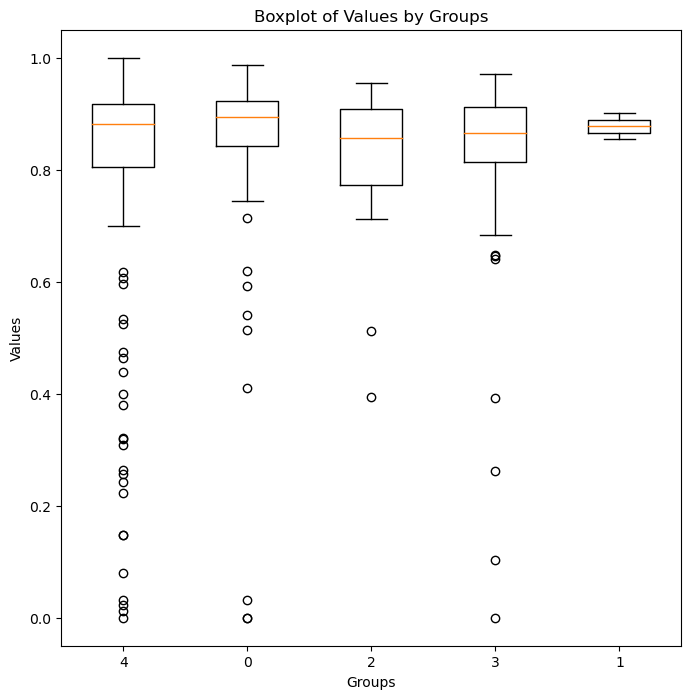

In [50]:
# Convert dictionary to lists for boxplot
data = [values for key, values in gmGenes.items()]
print([len(values) for key,values in gmGenes.items()])

# Create boxplot
plt.boxplot(data)

# Set labels for x-axis
plt.xticks(range(1, len(gmGenes) + 1), gmGenes.keys())
# plt.ylim(0.7,1)

# Set labels for x and y axes
plt.xlabel('Groups')
plt.ylabel('Values')

# Set title
plt.title('Boxplot of Values by Groups')

# Show the plot
plt.show()

[451, 266, 116, 339, 4]


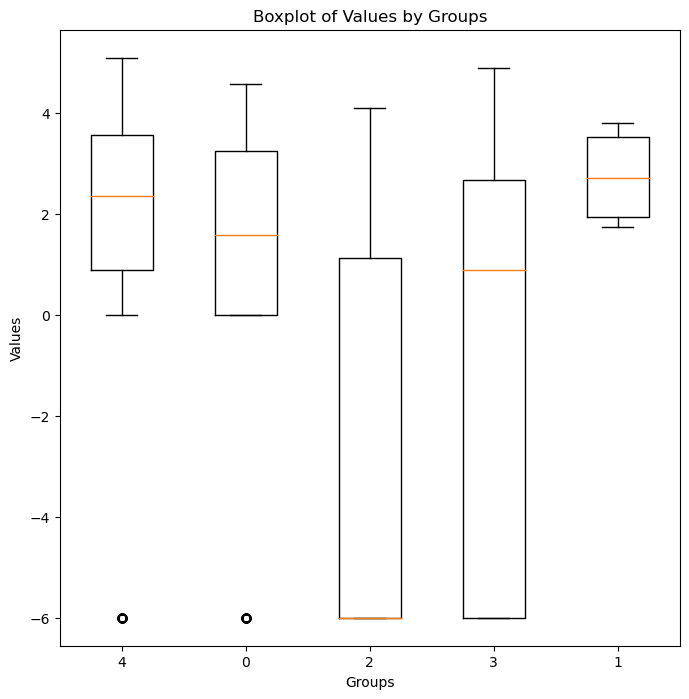

In [51]:
# Convert dictionary to lists for boxplot
data = [values for key, values in gmGEX.items()]
print([len(values) for key,values in gmGEX.items()])

# Create boxplot
plt.boxplot(data)

# Set labels for x-axis
plt.xticks(range(1, len(gmGEX) + 1), gmGEX.keys())

# Set labels for x and y axes
plt.xlabel('Groups')
plt.ylabel('Values')

# Set title
plt.title('Boxplot of Values by Groups')

# Show the plot
plt.show()

In [141]:
nucGE.head()

,gene_ID,Rep1
0,ENSG00000243485,1
1,ENSG00000237613,0
2,ENSG00000186092,0
3,ENSG00000238009,21
4,ENSG00000239945,0


In [ ]:

for community_id, nodes in communities.items():
    sGenes = list(nucSE[nucSE['gene_ID'].isin(nodes)]['gene_ID'])
    eGenes = list(nucGE[nucGE['gene_ID'].isin(nodes)]['gene_ID'])
    commonGenes = list(set(sGenes) & set(eGenes))
    for gene in commonGenes:
        n = nucSE[nucSE['gene_ID'] == gene]['Nuclear']
        e = nucGE[nucGE['gene_ID'] == gene]['Rep1']
    seValues = nucSE[nucSE['gene_ID'].isin(nodes)]['Nuclear']
    gmGenes[community_id] = seValues
    gexValues = nucGE[nucGE['gene_ID'].isin(nodes)]['Rep1']
    gexNorm = [np.log10(item + 1/(10**6)) for item in gexValues]
    gmGEX[community_id] = gexNorm

In [129]:
x = np.array([1,3,5,7,8,9, 10, 15])
y = np.array([10, 20, 30, 40, 50, 60, 70, 80])
np.corrcoef(x,y)

array([[1.        , 0.97489441],
       [0.97489441, 1.        ]])

In [92]:
hg_genes_se = nucSE[nucSE['gene_ID'].isin(clust_hg)]['Nuclear']

,gene_ID,SE_var,Cytosolic,Nuclear,WholeCell,nucStatus
0,ENSG00000000419,0.001063,0.943271,0.891642,0.951967,High
1,ENSG00000000457,0.017272,0.897960,0.640562,0.815354,Medium
2,ENSG00000000460,0.000561,0.955136,0.907759,0.931873,High
3,ENSG00000000938,0.001399,0.922836,0.848781,0.894995,High
4,ENSG00000001036,0.010581,0.928505,0.731498,0.881335,Medium
...,...,...,...,...,...,...
11309,ENSG00000287839,NaN,NaN,0.913043,NaN,High
11310,ENSG00000287892,NaN,NaN,0.004975,NaN,Low
11311,ENSG00000287895,0.000620,0.831240,0.799134,0.782206,High
11312,ENSG00000287920,0.001463,NaN,0.176675,0.230769,Low


In [53]:
clust_hg = list(set(chrFile_wBinID[chrFile_wBinID['ID'].isin(impReads_pm2)]['geneID']))
print(len(clust_hg))

610


In [233]:
clust_hg

['ENSG00000272343',
 'ENSG00000164736',
 'ENSG00000164687',
 'ENSG00000215262',
 'ENSG00000047249',
 'ENSG00000133742',
 'ENSG00000253238',
 'ENSG00000254380',
 'ENSG00000164893',
 'ENSG00000287654',
 'ENSG00000008988',
 'ENSG00000180543',
 'ENSG00000174417',
 'ENSG00000253369',
 'ENSG00000253669',
 'ENSG00000272138',
 'ENSG00000260955',
 'ENSG00000254081',
 'ENSG00000083307',
 'ENSG00000120992',
 'ENSG00000121022',
 'ENSG00000169439',
 'ENSG00000155090',
 'ENSG00000286766',
 'ENSG00000178125',
 'ENSG00000164764',
 'ENSG00000164749',
 'ENSG00000253477',
 'ENSG00000198846',
 'ENSG00000165084',
 'ENSG00000172817',
 'ENSG00000253553',
 'ENSG00000253773',
 'ENSG00000164796',
 'ENSG00000197140',
 'ENSG00000076641',
 'ENSG00000147614',
 'ENSG00000253583',
 'ENSG00000254349',
 'ENSG00000253642',
 'ENSG00000214954',
 'ENSG00000186106',
 'ENSG00000280725',
 'ENSG00000253778',
 'ENSG00000104331',
 'ENSG00000137547',
 'ENSG00000155097',
 'ENSG00000254001',
 'ENSG00000205038',
 'ENSG00000147408',


## Get SE concordance per read not per cluster

In [67]:
print(impRecords_pm2[['readID','geneName','geneID']].head())
nucSE.head()

                                readID geneName           geneID
1111  Read:6955529_Card:12_Batch:1c575    BET1L  ENSG00000177951
1545    Read:252953_Card:9_Batch:1c575    SIRT3  ENSG00000142082
1568  Read:17733835_Card:7_Batch:1c575    SIRT3  ENSG00000142082
1912  Read:11022742_Card:4_Batch:1c575    SIRT3  ENSG00000142082
1917    Read:252953_Card:9_Batch:1c575    SIRT3  ENSG00000142082


NameError: name 'nucSE' is not defined

In [58]:
nucSE.rename(columns = {'gene_ID':'geneID'},inplace = True)
pm2_wSE = pd.merge(impRecords_pm2[['readID','geneName','geneID']],nucSE,how = "left")

In [63]:
pm2_wSE.head()
pm2_avgNucSE = pm2_wSE.groupby('readID').agg({'Nuclear': ['count', 'mean']})
pm2_avgNucSE.columns = ['GeneCard', 'meanNucSE']
pm2_avgNucSE = pm2_avgNucSE[pm2_avgNucSE['GeneCard'] > 1]
pm2_avgNucSE.head()

,GeneCard,meanNucSE
readID,,
Read:10003358_Card:5_Batch:78d0d,3,0.672615
Read:10005749_Card:5_Batch:4a72b,2,0.511628
Read:10008906_Card:5_Batch:972fa,2,0.811467
Read:10012655_Card:4_Batch:e4379,3,0.915634
Read:10018715_Card:4_Batch:4a72b,3,0.726553


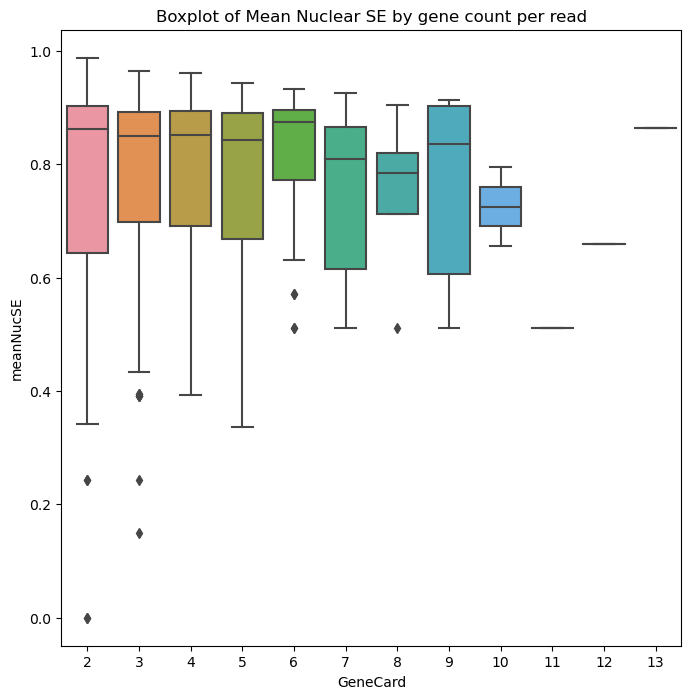

In [64]:
sns.boxplot(x='GeneCard', y='meanNucSE', data=pm2_avgNucSE)
plt.xlabel('GeneCard')
plt.ylabel('meanNucSE')
plt.title('Boxplot of Mean Nuclear SE by gene count per read')
plt.show()

# Run and debug script

In [3]:
import importlib
import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/')

Parsing arguments
Starting run: HCC1954 versus HG002
Running the full cycle on the two datasets
Reading in file and normalizing matrix
Plotting normalized matrix to .pdf
Reading in file and normalizing matrix
Plotting normalized matrix to .pdf
Obtained sorted difference matrix
Plotting and saving sorted diffMat
Getting enriched reads per sample
(113, 1064)
(114, 712)
Plotting all the graphs for HCC1954
Getting hypergraph
Raw line graph from hypergraph
Weighted graph from incDF and read support
Plotting weighted graph
Writing weighted graph to file.
Clustering w/ Louvain to get communities
Writing out louvain clusters to csv
Plotting louvain


/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Plotting all the graphs for HG002
Getting hypergraph
Raw line graph from hypergraph
Weighted graph from incDF and read support
Plotting weighted graph
Writing weighted graph to file.
Clustering w/ Louvain to get communities
Writing out louvain clusters to csv
Plotting louvain


/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


All done!

IPython CPU timings (estimated):
  User   :      10.32 s.
  System :       3.85 s.
Wall time:       8.10 s.


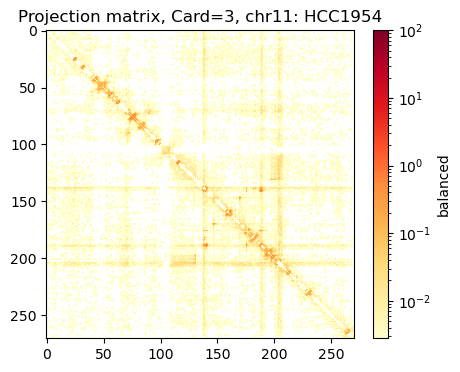

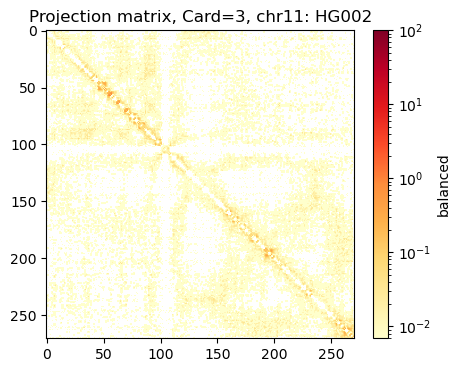

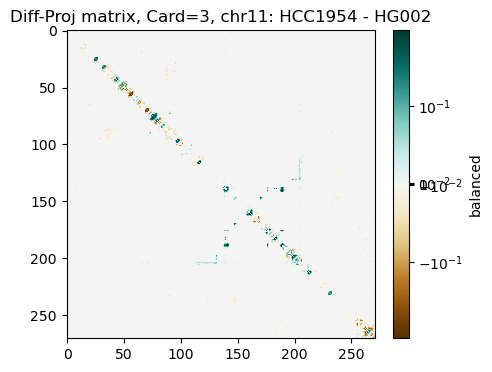

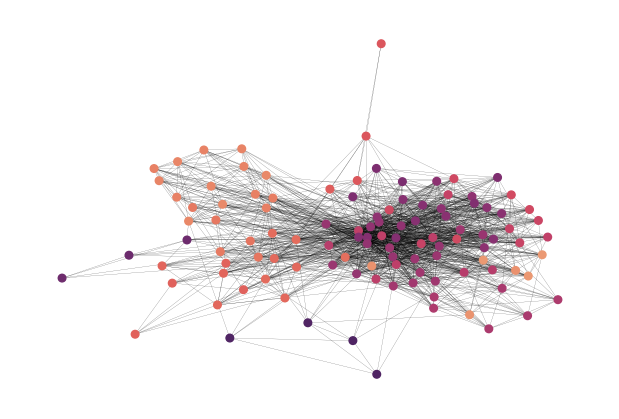

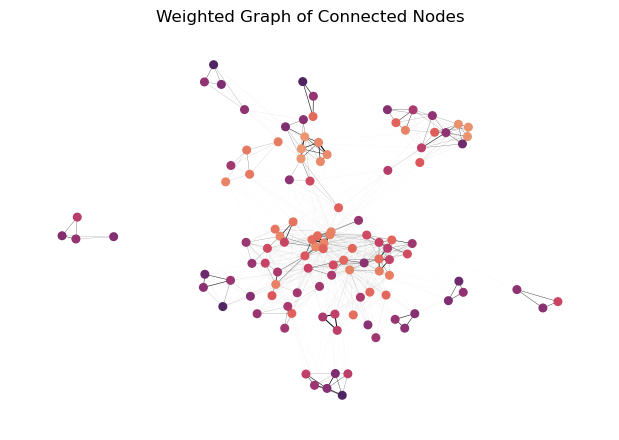

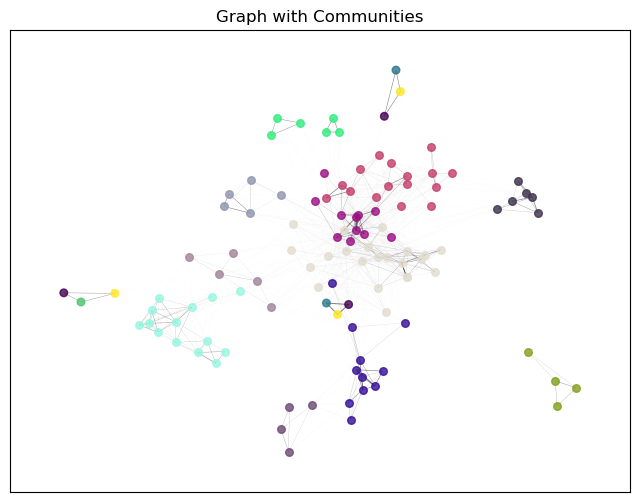

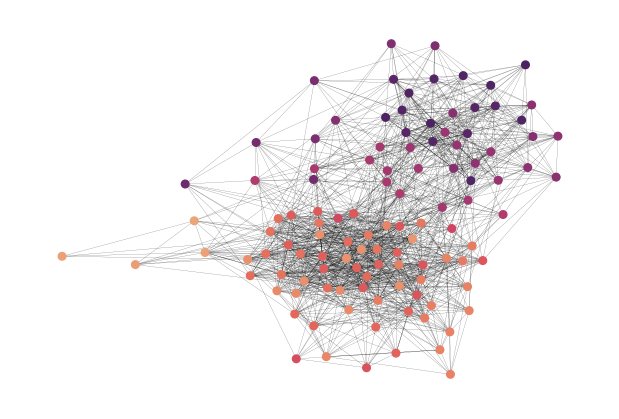

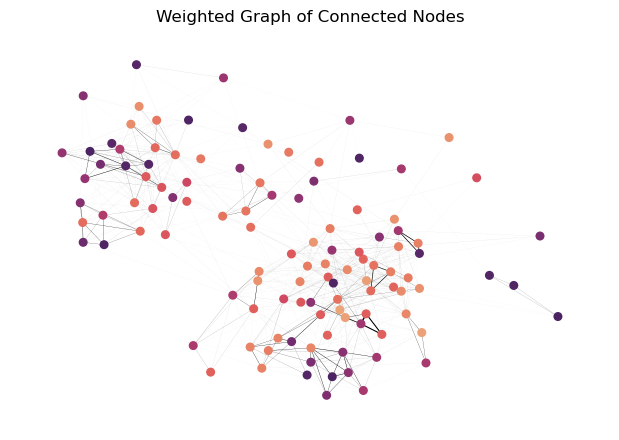

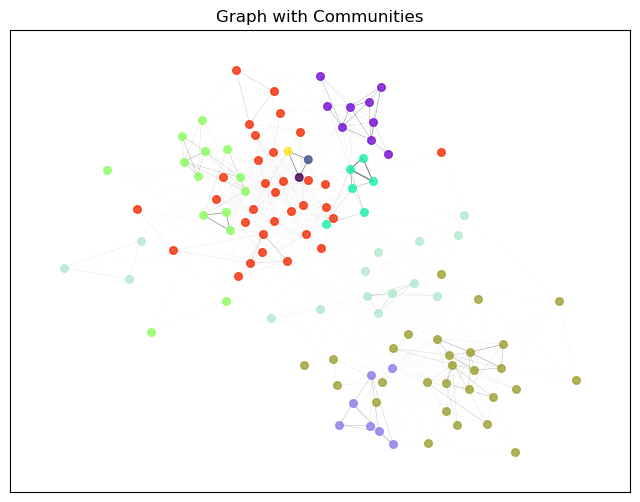

In [34]:
%run -t ../pythonScripts/v4.differentialAnalysis.py '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/' 'differentialAnalysis/hcc_vs_hg/' 'projMatPlots_cellLines/matrices/' 'chr11' '3' 'HCC1954' 'HG002'